In [1]:
!pip install rasterio

import os
import shutil
import random
import copy
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os.path as osp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader

import torchvision
from tqdm import tqdm, notebook as tqdm_notebook
import rasterio
from osgeo import gdal

data_root = '/kaggle/input/2023-ieee-grss-data-fusion-contest/track2'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 82.0 MB/s eta 0:00:00:00:0100:01


## Data root directory where we store the rgb, sar, dsm data

## Here, we merge the rgb and sar data together and store it in '/kaggle/working/track2/train/merge'

In [2]:
def read_img(filename):
    dataset = gdal.Open(filename)
    im_data = dataset.ReadAsArray()
    im_proj = dataset.GetProjection()
    im_geotrans = dataset.GetGeoTransform()
    return im_data, im_proj, im_geotrans

def write_img(filename, im_proj, im_geotrans, im_data):
    if len(im_data.shape) == 3:
        bands, height, width = im_data.shape
    else:
        bands, (height, width) = 1, im_data.shape

    driver = gdal.GetDriverByName("GTiff")
    datatype = gdal.GDT_Float32
    dataset = driver.Create(filename, width, height, bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)

    if bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
    del dataset

def make_merge(rgb_path, sar_path, merge_path):
    data_rgb, proj, geotrans = read_img(rgb_path)
    data_sar, _, _ = read_img(sar_path)
    if data_sar.ndim == 2:
        data_sar = data_sar[np.newaxis, :, :]
    data_merge = np.concatenate([data_rgb, data_sar], axis=0)
    write_img(merge_path, proj, geotrans, data_merge)

# Merge all RGB and SAR images into 4-channel
root = os.path.join(data_root, 'train')
merged_dir = os.path.join('/kaggle/working/track2/train/merge')
os.makedirs(merged_dir, exist_ok=True)

rgb_dir = os.path.join(root, 'rgb')
sar_dir = os.path.join(root, 'sar')

for f in tqdm(os.listdir(rgb_dir)):
    if f.endswith('.tif') and os.path.exists(os.path.join(sar_dir, f)):
        rgb_path = os.path.join(rgb_dir, f)
        sar_path = os.path.join(sar_dir, f)
        merge_path = os.path.join(merged_dir, f)
        make_merge(rgb_path, sar_path, merge_path)

print("✅ Merged RGB + SAR saved to:", merged_dir)


100%|██████████| 1773/1773 [01:58<00:00, 14.94it/s]

✅ Merged RGB + SAR saved to: /kaggle/working/track2/train/merge


## Here we copy the dsm files to the kaggle working directory and convert them to numpy arrays

In [3]:
src_folder = os.path.join(data_root, "train", "dsm")  # ✅ fixed
dst_folder = "/kaggle/working/track2/train/dsm"

os.makedirs(dst_folder, exist_ok=True)

# Copy only .tif files
for f in os.listdir(src_folder):
    if f.endswith(".tif"):
        shutil.copy(os.path.join(src_folder, f), os.path.join(dst_folder, f))

print("✅ DSM .tif files copied to writable folder.")

tif_folder = "/kaggle/working/track2/train/dsm"
npy_folder = "/kaggle/working/track2/train/dsmnpy"
os.makedirs(npy_folder, exist_ok=True)

for fname in os.listdir(tif_folder):
    if fname.endswith(".tif"):
        tif_path = os.path.join(tif_folder, fname)
        npy_path = os.path.join(npy_folder, fname.replace(".tif", ".npy"))

        with rasterio.open(tif_path) as src:
            arr = src.read(1)
            np.save(npy_path, arr)

print("✅ DSM conversion to .npy complete.")

✅ DSM .tif files copied to writable folder.
✅ DSM conversion to .npy complete.


## Here, we create divide the training folder into train (70%), validation (20%), and test (10%), put the image ids into seperate files and store them

In [4]:
rgb_dir = os.path.join(data_root, "train", "rgb")  # ✅ use original
dsm_dir = "/kaggle/working/track2/train/dsmnpy"    # ✅ use working dir for npy DSMs

all_merge = [f for f in os.listdir(rgb_dir) if f.endswith(".tif")]
valid_samples = []

for f in all_merge:
    name = os.path.splitext(f)[0]
    if os.path.exists(os.path.join(dsm_dir, f"{name}.npy")):
        valid_samples.append(name)

random.shuffle(valid_samples)
train_split = int(0.7 * len(valid_samples))
val_split = int(0.9 * len(valid_samples))

train_ids = valid_samples[:train_split]
val_ids = valid_samples[train_split:val_split]
test_ids = valid_samples[val_split:]

with open("/kaggle/working/train_list.txt", 'w') as f:
    f.write("\n".join(train_ids))
with open("/kaggle/working/val_list.txt", 'w') as f:
    f.write("\n".join(val_ids))
with open("/kaggle/working/test_list.txt", 'w') as f:
    f.write("\n".join(test_ids))

print("✅ Split lists saved (train/val/test)")


✅ Split lists saved (train/val/test)


## The next two cells are for data loading, now we create the dataset class, and then load the images

In [5]:
class ISPRSDataSet(data.Dataset):
    def __init__(self, root, list_path, crop_size=(512, 512), mean=(128, 128, 128, 128), scale=False, mirror=True):
        self.root = root
        self.list_path = list_path
        self.crop_h, self.crop_w = crop_size
        self.mean = mean
        self.scale = scale
        self.is_mirror = mirror
        self.img_ids = [i_id.strip() for i_id in open(list_path)]
        self.files = []

        for name in self.img_ids:
            img_file = osp.join(self.root, "merge/%s.tif" % name)
            dsm_file = osp.join(self.root, "dsmnpy/%s.npy" % name)
            self.files.append({
                "img": img_file,
                "dsm": dsm_file,
                "name": name
            })

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        datafiles = self.files[index]
        # Read 4‑channel image as (C, H, W)
        with rasterio.open(datafiles["img"]) as src:
            image = src.read().astype(np.float32)
        # Read DSM as (H, W, 1)
        dsm = np.load(datafiles["dsm"]).astype(np.float32)
        dsm = np.reshape(dsm, (dsm.shape[0], dsm.shape[1], 1))
    
        # Normalize
        image = image - np.array(self.mean)[:, None, None]
        # dsm = dsm / 183.17412
    
        # --- Crop center ---
        _, h, w = image.shape
        if h < self.crop_h or w < self.crop_w:
            raise ValueError(f"Cannot crop to {self.crop_h}×{self.crop_w} from image size {h}×{w}")
        h_off = (h - self.crop_h) // 2
        w_off = (w - self.crop_w) // 2
    
        # Channel‑first crop
        image = image[:, h_off:h_off + self.crop_h, w_off:w_off + self.crop_w]
        dsm = dsm[h_off:h_off + self.crop_h, w_off:w_off + self.crop_w, :]
    
        # Transpose DSM to (1, H, W)
        dsm = dsm.transpose((2, 0, 1))
    
        return image.copy(), dsm.copy(), (h, w), datafiles["name"]


In [6]:
final_data_root = "/kaggle/working/track2/train"

train_dataset = ISPRSDataSet(
    root=final_data_root,
    list_path="/kaggle/working/train_list.txt",
    crop_size=(512, 512)
)

val_dataset = ISPRSDataSet(
    root=final_data_root,
    list_path="/kaggle/working/val_list.txt",
    crop_size=(512, 512)
)

test_dataset = ISPRSDataSet(
    root=final_data_root,
    list_path="/kaggle/working/test_list.txt",
    crop_size=(512, 512)
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)


# From this point onwards, we are building the model

## The model architecture

In [7]:
import torch
import torch.nn as nn
from torch.nn import functional as F

affine_par = True

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None, fist_dilation=1, multi_grid=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(inplanes, planes, kernel_size=1, bias=False),
                                   nn.BatchNorm2d(planes),
                                   nn.ReLU(inplace=False))
        self.conv2 = nn.Sequential(nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=dilation*multi_grid, dilation=dilation*multi_grid, bias=False),
                                   nn.BatchNorm2d(planes),
                                   nn.ReLU(inplace=False))
        self.conv3 = nn.Sequential(nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False),
                                   nn.BatchNorm2d(planes * 4))

        self.relu_inplace = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out + residual      
        out = self.relu_inplace(out)
        return out

class ASPPModule(nn.Module):
    """
    Reference: 
        Chen, Liang-Chieh, et al. *"Rethinking Atrous Convolution for Semantic Image Segmentation."*
    """
    def __init__(self, features, inner_features=256, out_features=512, dilations=(12, 24, 36)):
        super(ASPPModule, self).__init__()

        self.conv1 = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                                   nn.Conv2d(features, inner_features, kernel_size=1, padding=0, dilation=1, bias=False),
                                   nn.BatchNorm2d(inner_features))
        self.conv2 = nn.Sequential(nn.Conv2d(features, inner_features, kernel_size=1, padding=0, dilation=1, bias=False),
                                   nn.BatchNorm2d(inner_features))
        self.conv3 = nn.Sequential(nn.Conv2d(features, inner_features, kernel_size=3, padding=dilations[0], dilation=dilations[0], bias=False),
                                   nn.BatchNorm2d(inner_features))
        self.conv4 = nn.Sequential(nn.Conv2d(features, inner_features, kernel_size=3, padding=dilations[1], dilation=dilations[1], bias=False),
                                   nn.BatchNorm2d(inner_features))
        self.conv5 = nn.Sequential(nn.Conv2d(features, inner_features, kernel_size=3, padding=dilations[2], dilation=dilations[2], bias=False),
                                   nn.BatchNorm2d(inner_features))

        self.bottleneck = nn.Sequential(
            nn.Conv2d(inner_features * 5, out_features, kernel_size=1, padding=0, dilation=1, bias=False),
            nn.BatchNorm2d(out_features),
            nn.Dropout2d(0.1)
            )
        
    def forward(self, x):
        _, _, h, w = x.size()
        feat1 = F.interpolate(self.conv1(x), size=(h, w), mode='bilinear', align_corners=True)
        feat2 = self.conv2(x)
        feat3 = self.conv3(x)
        feat4 = self.conv4(x)
        feat5 = self.conv5(x)
        out = torch.cat((feat1, feat2, feat3, feat4, feat5), 1)

        bottle = self.bottleneck(out)
        return bottle

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        self.inplanes = 128
        super(ResNet, self).__init__()
        self.conv1 = nn.Sequential(conv3x3(4, 64, stride=2),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=False))
        self.conv2 = nn.Sequential(conv3x3(64, 64),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=False))
        self.conv3 = nn.Sequential(conv3x3(64, 128),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(inplace=False))

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.relu = nn.ReLU(inplace=False)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation=4, multi_grid=(1,1,1))

        # self.head = nn.Sequential(ASPPModule(2048),
        #                           nn.Conv2d(512, 1, kernel_size=1, stride=1, padding=0, bias=True),
        #                           nn.Sigmoid())

        self.head = nn.Sequential(ASPPModule(2048),
                                  nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                  nn.BatchNorm2d(512),
                                  nn.Dropout2d(0.1),
                                  nn.Conv2d(512, 1, kernel_size=1, stride=1, padding=0, bias=True),
                                  nn.Softplus())
                                  # nn.ReLU(inplace=False))
                                  # nn.Sigmoid())

        self.dsn = nn.Sequential(nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
                                 nn.BatchNorm2d(512),
                                 nn.Dropout2d(0.1),
                                 nn.Conv2d(512, 1, kernel_size=1, stride=1, padding=0, bias=True))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x_dsn = self.dsn(x)
        x = self.layer4(x)

        x = self.head(x)

        return [x, x_dsn]

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, multi_grid=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion,affine = affine_par))

        layers = []
        generate_multi_grid = lambda index, grids: grids[index%len(grids)] if isinstance(grids, tuple) else 1
        layers.append(block(self.inplanes, planes, stride,dilation=dilation, downsample=downsample, multi_grid=generate_multi_grid(0, multi_grid)))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation, multi_grid=generate_multi_grid(i, multi_grid)))

        return nn.Sequential(*layers)


def Res_Deeplab(num_classes=6):
    model = ResNet(Bottleneck,[3, 4, 23, 3], num_classes)
    return model

# initializing the model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Res_Deeplab(num_classes=1).to(device)

criterion = nn.SmoothL1Loss()  # same loss used as the baseline paper

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


# metrics

In [9]:
def compute_delta_metrics(pred, gt, thresholds=[1.25, 1.25**2, 1.25**3]):
    eps = 1e-6
    pred = pred.clamp(min=eps)
    gt = gt.clamp(min=eps)

    ratio = torch.max(pred / gt, gt / pred)

    deltas = []
    for t in thresholds:
        valid = (ratio < t).float()
        deltas.append(valid.mean().item())

    return deltas  # returns δ1, δ2, δ3

# not a metric but to set to evaluation mode
def set_batchnorm_eval(m):
    if isinstance(m, nn.BatchNorm2d):
        m.eval()


In [2]:
model.load_state_dict(torch.load("/kaggle/working/model.pth"))

NameError: name 'model' is not defined

# Training loop

In [10]:
train_losses, val_losses, val_rmses, val_maes = [], [], [], []
best_model_wts = copy.deepcopy(model.state_dict())
best_rmse = float("inf")
num_epochs = 10

for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    model.train()
    total_loss = 0

    for images, targets, _, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, targets = images.to(device).float(), targets.to(device).float()
        
        # Log-transform targets
        targets_log = torch.log1p(targets)

        if images.shape[0] == 1:
            print("Wha?")
            model.apply(set_batchnorm_eval)

        # Predict log-values
        outputs_log = model(images)[0].squeeze(1)
        outputs_log = F.interpolate(outputs_log.unsqueeze(1), size=targets.shape[2:], mode='bilinear', align_corners=True)

        # Loss in log-space
        loss = criterion(outputs_log, targets_log)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    epoch_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # ===== Validation =====
    model.eval()
    total_val_loss = 0
    batch_rmses = []
    batch_maes = []

    with torch.no_grad():
        for images, targets, _, _ in val_loader:
            images = images.to(device).float()
            targets = targets.to(device).float()
            
            # Log-transform targets for loss
            targets_log = torch.log1p(targets)

            # Predict log-values
            outputs_log = model(images)[0].squeeze(1)
            outputs_log = F.interpolate(outputs_log.unsqueeze(1), size=targets.shape[2:], mode='bilinear', align_corners=True)

            # Convert back to height-space
            outputs = torch.expm1(outputs_log)

            # Loss in height-space for interpretability
            loss = criterion(outputs, targets)
            total_val_loss += loss.item() * images.size(0)

            rmse = torch.sqrt(F.mse_loss(outputs, targets)).item()
            mae = torch.mean(torch.abs(outputs - targets)).item()

            batch_rmses.append(rmse)
            batch_maes.append(mae)

    epoch_val_loss = total_val_loss / len(val_loader.dataset)
    avg_rmse = sum(batch_rmses) / len(batch_rmses)
    avg_mae = sum(batch_maes) / len(batch_maes)

    val_losses.append(epoch_val_loss)
    val_rmses.append(avg_rmse)
    val_maes.append(avg_mae)

    print(f"Epoch {epoch+1} | Train Loss (log): {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | RMSE: {avg_rmse:.4f} | MAE: {avg_mae:.4f}")

    scheduler.step(epoch_val_loss)

    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_model_wts = copy.deepcopy(model.state_dict())
        print("✅ New best model saved!")

# Load best weights
model.load_state_dict(best_model_wts)

Epoch 1/10 - Training: 100%|█████████▉| 310/311 [05:52<00:01,  1.13s/it]

Wha?


Epoch 1/10 - Training: 100%|██████████| 311/311 [05:52<00:00,  1.13s/it]


Epoch 1 | Train Loss (log): 0.4974 | Val Loss: 252777221339238048.0000 | RMSE: inf | MAE: 251357124590141216.0000


Epoch 2/10 - Training: 100%|█████████▉| 310/311 [05:51<00:01,  1.13s/it]

Wha?


Epoch 2/10 - Training: 100%|██████████| 311/311 [05:51<00:00,  1.13s/it]


Epoch 2 | Train Loss (log): 0.4101 | Val Loss: 4.8084 | RMSE: 10.2439 | MAE: 5.0194
✅ New best model saved!


Epoch 3/10 - Training: 100%|█████████▉| 310/311 [05:51<00:01,  1.13s/it]

Wha?


Epoch 3/10 - Training: 100%|██████████| 311/311 [05:51<00:00,  1.13s/it]


Epoch 3 | Train Loss (log): 0.3824 | Val Loss: 7.5657 | RMSE: 11.2767 | MAE: 8.0181


Epoch 4/10 - Training: 100%|█████████▉| 310/311 [05:51<00:01,  1.13s/it]

Wha?


Epoch 4/10 - Training: 100%|██████████| 311/311 [05:51<00:00,  1.13s/it]


Epoch 4 | Train Loss (log): 0.3625 | Val Loss: 16.8517 | RMSE: 1193.6600 | MAE: 17.0269


Epoch 5/10 - Training: 100%|█████████▉| 310/311 [05:51<00:01,  1.13s/it]

Wha?


Epoch 5/10 - Training: 100%|██████████| 311/311 [05:51<00:00,  1.13s/it]


Epoch 5 | Train Loss (log): 0.3394 | Val Loss: 3.4561 | RMSE: 7.5997 | MAE: 3.7244
✅ New best model saved!


Epoch 6/10 - Training: 100%|█████████▉| 310/311 [05:50<00:01,  1.13s/it]

Wha?


Epoch 6/10 - Training: 100%|██████████| 311/311 [05:51<00:00,  1.13s/it]


Epoch 6 | Train Loss (log): 0.3477 | Val Loss: 3.2254 | RMSE: 7.0722 | MAE: 3.5022
✅ New best model saved!


Epoch 7/10 - Training: 100%|█████████▉| 310/311 [05:50<00:01,  1.13s/it]

Wha?


Epoch 7/10 - Training: 100%|██████████| 311/311 [05:51<00:00,  1.13s/it]


Epoch 7 | Train Loss (log): 0.3168 | Val Loss: 3.4064 | RMSE: 7.0429 | MAE: 3.7188
✅ New best model saved!


Epoch 8/10 - Training: 100%|█████████▉| 310/311 [05:50<00:01,  1.13s/it]

Wha?


Epoch 8/10 - Training: 100%|██████████| 311/311 [05:51<00:00,  1.13s/it]


Epoch 8 | Train Loss (log): 0.3048 | Val Loss: 4.6126 | RMSE: 8.1481 | MAE: 4.9817


Epoch 9/10 - Training: 100%|█████████▉| 310/311 [05:50<00:01,  1.13s/it]

Wha?


Epoch 9/10 - Training: 100%|██████████| 311/311 [05:51<00:00,  1.13s/it]


Epoch 9 | Train Loss (log): 0.2909 | Val Loss: 5.3203 | RMSE: 9.8037 | MAE: 5.6494


Epoch 10/10 - Training: 100%|█████████▉| 310/311 [05:50<00:01,  1.13s/it]

Wha?


Epoch 10/10 - Training: 100%|██████████| 311/311 [05:51<00:00,  1.13s/it]


Epoch 10 | Train Loss (log): 0.2560 | Val Loss: 3.7487 | RMSE: 8.4158 | MAE: 3.9591


<All keys matched successfully>

In [1]:
# torch.save(model.state_dict(), "/kaggle/working/model.pth")

model.eval()
d1_total, d2_total, d3_total = 0, 0, 0
num_batches = 0

with torch.no_grad():
    for images, targets, _, _ in test_loader:
        images, targets = images.to(device).float(), targets.to(device).float()
        outputs = model(images)[0].squeeze(1)
        outputs = F.interpolate(outputs.unsqueeze(1), size=targets.shape[2:], mode='bilinear', align_corners=True).squeeze(1)

        d1, d2, d3 = compute_delta_metrics(outputs, targets)
        d1_total += d1
        d2_total += d2
        d3_total += d3
        num_batches += 1

avg_d1 = d1_total / num_batches
avg_d2 = d2_total / num_batches
avg_d3 = d3_total / num_batches

print(f"📏 Final Test δ Metrics — δ₁: {avg_d1:.4f} | δ₂: {avg_d2:.4f} | δ₃: {avg_d3:.4f}")


NameError: name 'model' is not defined

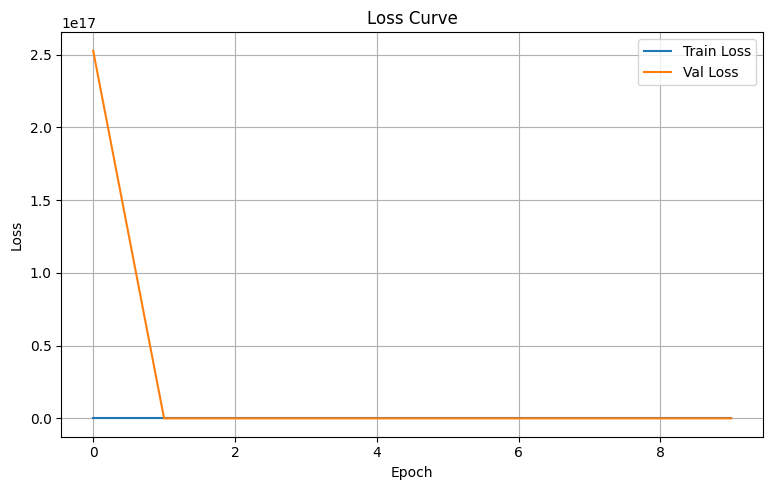

In [12]:
# Plot Training & Validation Loss
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


In [13]:
model.eval()
test_rmse_total = 0
test_mae_total = 0
num_batches = 0

with torch.no_grad():
    for images, targets, _, _ in test_loader:
        images, targets = images.to(device).float(), targets.to(device).float()
        outputs = model(images)[0].squeeze(1)
        outputs = F.interpolate(outputs.unsqueeze(1), size=targets.shape[2:], mode='bilinear', align_corners=True)

        rmse = torch.sqrt(F.mse_loss(outputs, targets)).item()
        mae = torch.mean(torch.abs(outputs - targets)).item()

        test_rmse_total += rmse
        test_mae_total += mae
        num_batches += 1

avg_test_rmse = test_rmse_total / num_batches
avg_test_mae = test_mae_total / num_batches

print(f"🧪 Final Test RMSE: {avg_test_rmse:.4f} | MAE: {avg_test_mae:.4f}")




🧪 Final Test RMSE: 9.4269 | MAE: 4.4952


In [14]:
model.eval()
test_rmse_total = 0
test_mae_total = 0
num_batches = 0

with torch.no_grad():
    for images, targets, _, _ in test_loader:
        images, targets = images.to(device).float(), targets.to(device).float()

        # Predict in log-space
        outputs_log = model(images)[0].squeeze(1)
        outputs_log = F.interpolate(outputs_log.unsqueeze(1), size=targets.shape[2:], mode='bilinear', align_corners=True)

        # Convert to height-space
        outputs = torch.expm1(outputs_log)

        # Evaluate on original (height) scale
        rmse = torch.sqrt(F.mse_loss(outputs, targets)).item()
        mae = torch.mean(torch.abs(outputs - targets)).item()

        test_rmse_total += rmse
        test_mae_total += mae
        num_batches += 1

avg_test_rmse = test_rmse_total / num_batches
avg_test_mae = test_mae_total / num_batches

print(f"🧪 Final Test RMSE: {avg_test_rmse:.4f} | MAE: {avg_test_mae:.4f}")

🧪 Final Test RMSE: 7.1957 | MAE: 3.5839



Sample 0:
  GT DSM Min: 0.00, Max: 10.66
  Pred DSM Min: 0.00, Max: 25.20

Sample 1:
  GT DSM Min: 0.00, Max: 12.28
  Pred DSM Min: 0.00, Max: 17.34

Sample 2:
  GT DSM Min: 0.00, Max: 24.61
  Pred DSM Min: 0.00, Max: 26.25

Sample 3:
  GT DSM Min: 0.00, Max: 20.51
  Pred DSM Min: 0.00, Max: 22.41


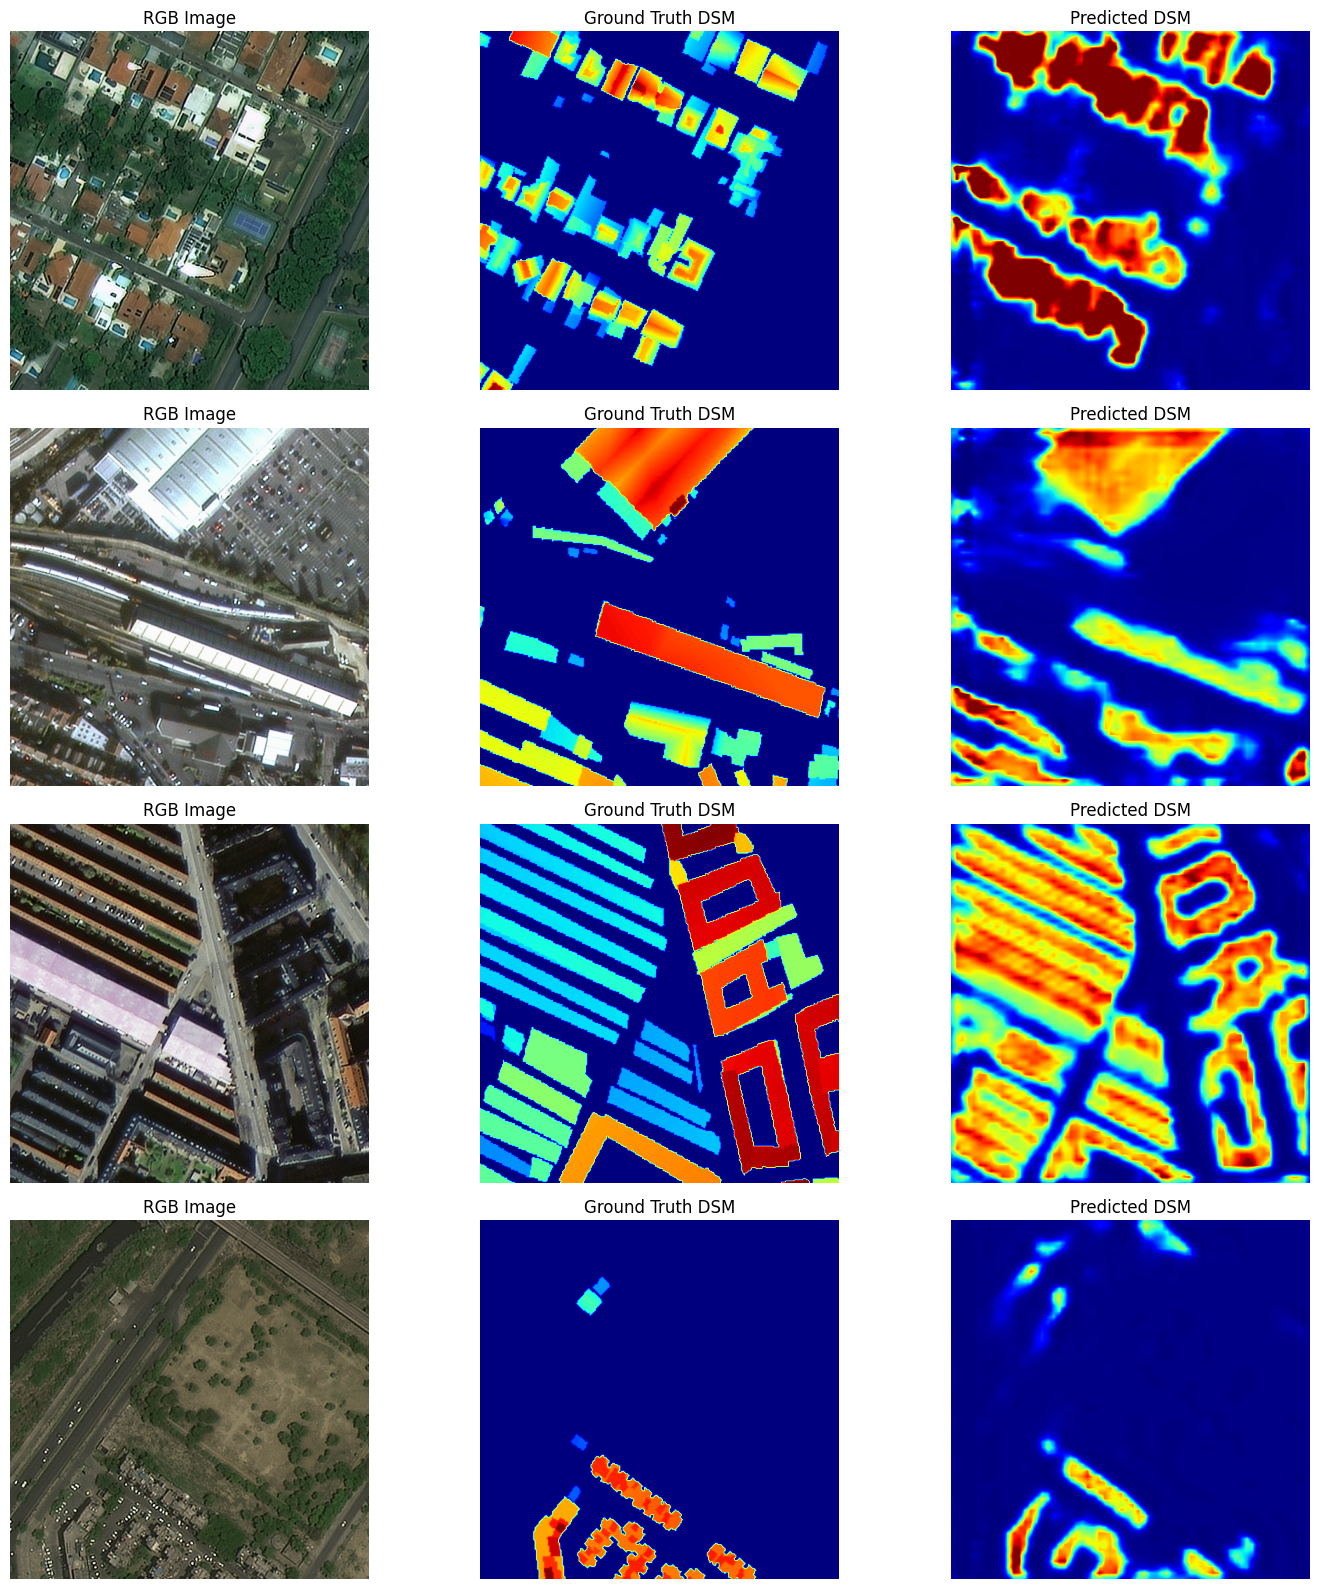

In [15]:
# Put model in evaluation mode
model.eval()

# Fetch one batch from test loader
images, targets, _, _ = next(iter(test_loader))
images = images.to(device).float()

# Get model prediction (in log-space)
with torch.no_grad():
    outputs_log = model(images)[0]
    outputs_log = F.interpolate(
        outputs_log,
        size=targets.shape[2:], 
        mode='bilinear', 
        align_corners=True
    )

# Convert predictions to height-space
outputs = torch.expm1(outputs_log)

# Move everything to CPU for visualization
images = images.cpu().numpy()           # shape: (B, 4, H, W)
targets = targets.cpu().numpy()         # shape: (B, 1, H, W)
outputs = outputs.cpu().numpy()         # shape: (B, 1, H, W)

# Show results for a few samples
num_samples = min(4, images.shape[0])
plt.figure(figsize=(15, num_samples * 4))

for i in range(num_samples):
    print(f"\nSample {i}:")
    print(f"  GT DSM Min: {targets[i][0].min():.2f}, Max: {targets[i][0].max():.2f}")
    print(f"  Pred DSM Min: {outputs[i][0].min():.2f}, Max: {outputs[i][0].max():.2f}")

for i in range(num_samples):
    # ---- RGB Image ----
    plt.subplot(num_samples, 3, i * 3 + 1)
    rgb = images[i][:3, :, :].transpose(1, 2, 0)   # (H, W, 3)
    rgb += np.array([128, 128, 128])               # Add mean if normalized like this
    rgb = np.clip(rgb, 0, 255).astype(np.uint8)
    plt.imshow(rgb)
    plt.title("RGB Image")
    plt.axis('off')

    # ---- Ground Truth DSM ----
    plt.subplot(num_samples, 3, i * 3 + 2)
    gt_dsm = targets[i][0]
    plt.imshow(gt_dsm, cmap='jet', vmin=0, vmax=gt_dsm.max())
    plt.title("Ground Truth DSM")
    plt.axis('off')

    # ---- Predicted DSM ----
    plt.subplot(num_samples, 3, i * 3 + 3)
    pred_dsm = outputs[i][0]
    plt.imshow(pred_dsm, cmap='jet', vmin=0, vmax=gt_dsm.max())
    plt.title("Predicted DSM")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Changes made

### Dataset:

Inclusion of SAR data - our original version did no such thing, I'm not quite sure how it still managed to perform, the given baseline did the same thing but it shouldn't have ever worked. Including SAR data was not trivial though sadly, requring quite a few changes to the get_item function of the dataset, along with some changes to the provided merge code (that one was provided in the baseline code)

No longer normalizing DSM values - to facilitate architectural change later on

### Architecture changes: 

Switched to a DeepLab-style encoder-decoder semantic segmentation network, base model provided in the original DFC code. Made a couple of changes to include SAR data, as well as shifting from Sigmoid activation head to a ReLU one which via trial and error has proved to be better so far. 

### Noticable issues:

Right now the model is acting more like a per pixel classifier, where the image segmentation part is coming along nicely but the height values - not so much. Need to identify how to fix it.


### Future plans: 
Log-normalization of DSM values
Better handling of SAR data (right now its treated as just another channel)
More activation functions to explore besides ReLU, Sigmoid
Exploring different optimizers - for these sorta models apparently SGD outperforms Adam over more epochs.